In [3]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import loompy

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='brg')
sc.logging.print_versions()
results_file = './write/pancreas.h5ad'

scanpy==1.3.1 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_loom(
    'pancreas.loom', sparse=True, cleanup=False, X_name='spliced', obs_names='CellID', var_names='Gene')

In [6]:
adata.var_names_make_unique()
genes = adata.var_names
obs = adata.obs_names

## Let's look at the highest expressing genes

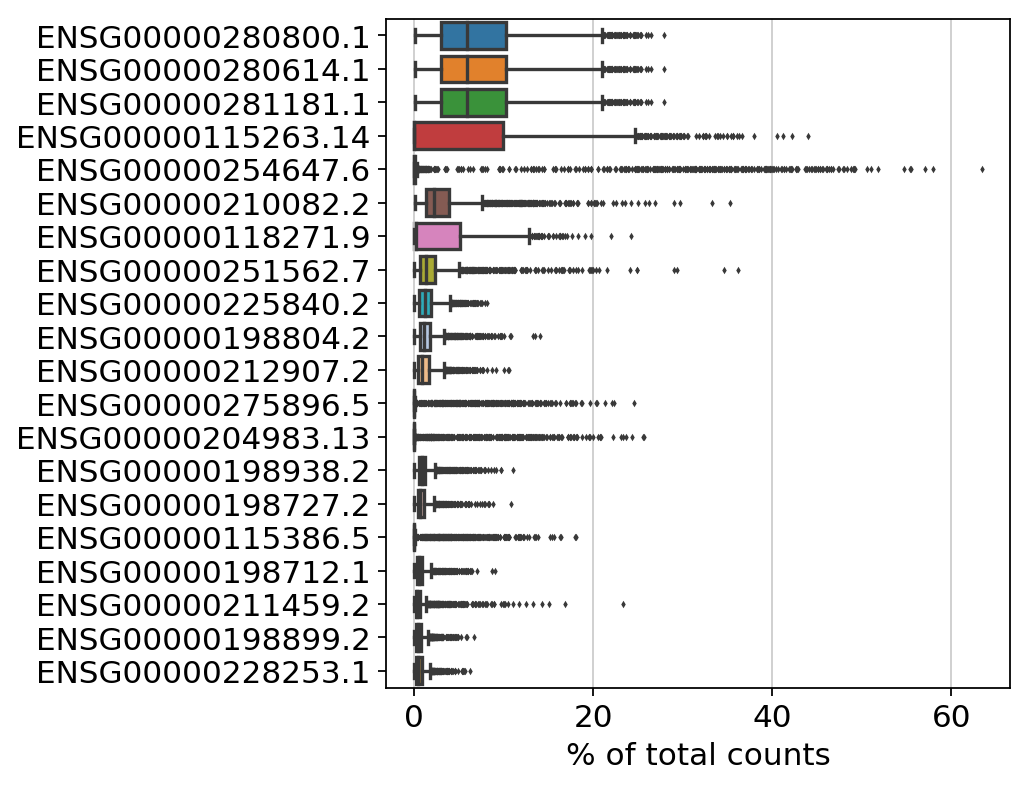

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

## PCA 

In [8]:
sc.tl.pca(adata, svd_solver='arpack')

... storing 'ACCUMULATION_LEVEL' as categorical
... storing 'ALIGNED_READS' as categorical
... storing 'Aligned 0 time' as categorical
... storing 'Aligned 1 time' as categorical
... storing 'Aligned >1 times' as categorical
... storing 'Aligned concordantly 1 time' as categorical
... storing 'Aligned concordantly >1 times' as categorical
... storing 'Aligned concordantly or discordantly 0 t' as categorical
... storing 'Aligned discordantly 1 time' as categorical
... storing 'BAD_CYCLES.FIRST_OF_PAIR' as categorical
... storing 'BAD_CYCLES.PAIR' as categorical
... storing 'BAD_CYCLES.SECOND_OF_PAIR' as categorical
... storing 'CORRECT_STRAND_READS' as categorical
... storing 'GC_DROPOUT' as categorical
... storing 'GC_NC_0_19' as categorical
... storing 'GC_NC_20_39' as categorical
... storing 'GC_NC_40_59' as categorical
... storing 'GC_NC_60_79' as categorical
... storing 'IGNORED_READS' as categorical
... storing 'INCORRECT_STRAND_READS' as categorical
... storing 'MAX_INSERT_SIZE' 

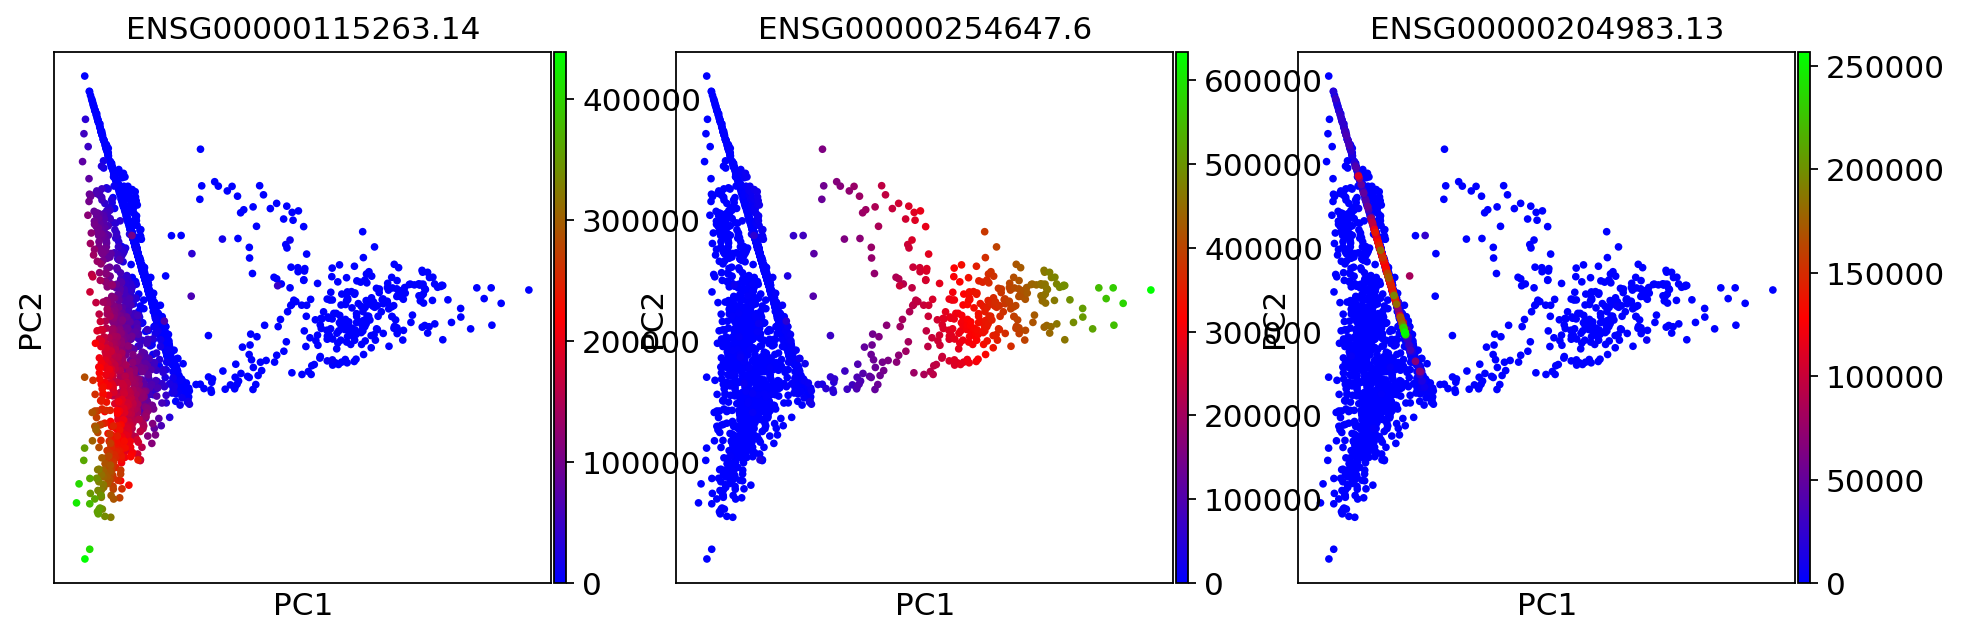

In [9]:
sc.pl.pca(adata, color=['ENSG00000115263.14', 'ENSG00000254647.6', 'ENSG00000204983.13'])

## Create neighborhood graph

In [10]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.65) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


## Compute and plot UMAP

In [11]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03.99) --> added
    'X_umap', UMAP coordinates (adata.obsm)


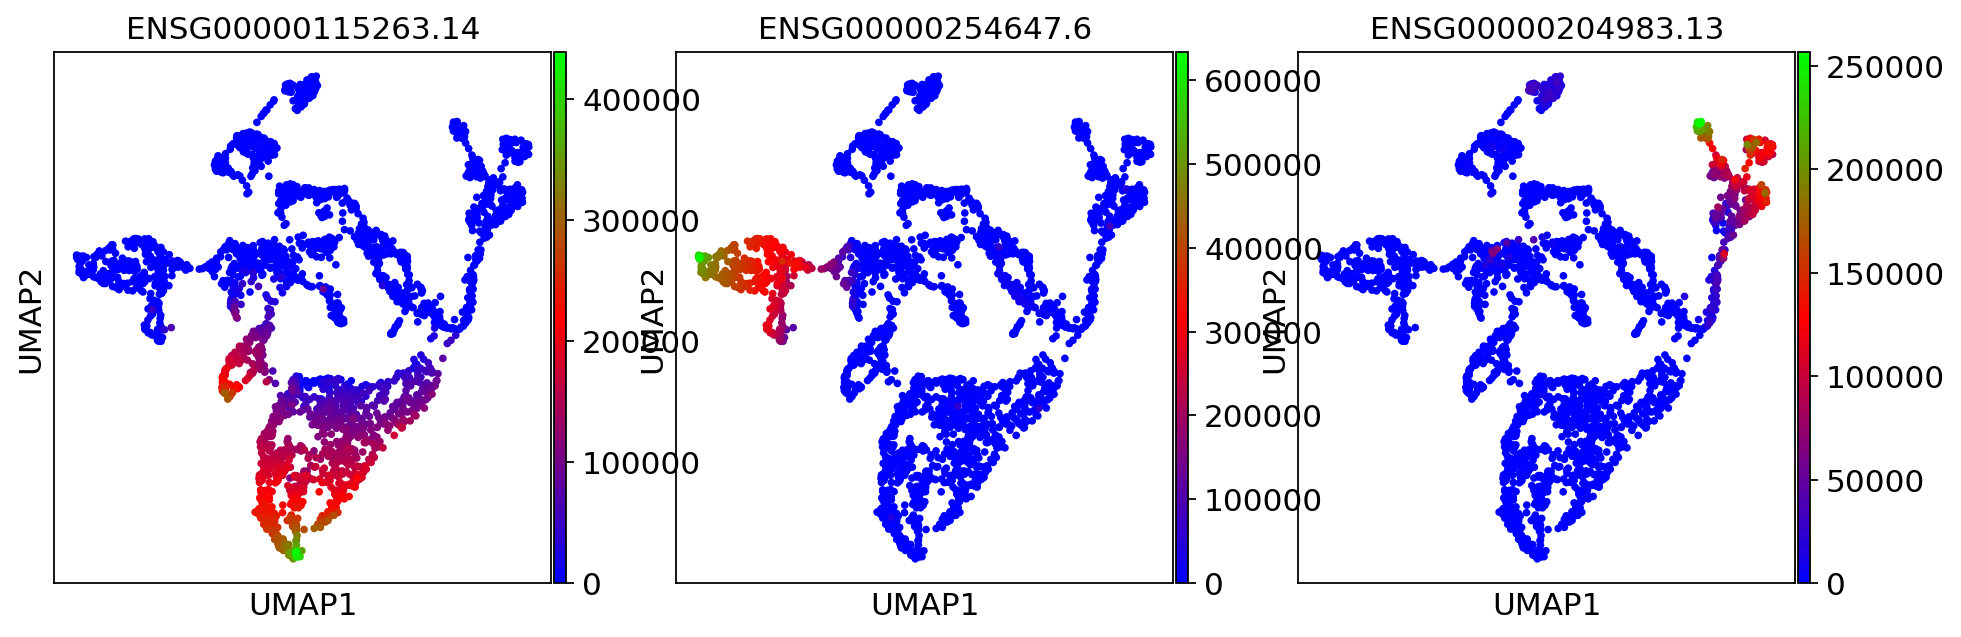

In [12]:
sc.pl.umap(adata, color=['ENSG00000115263.14', 'ENSG00000254647.6', 'ENSG00000204983.13'])

## Clustering the graph

In [13]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.12) --> found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


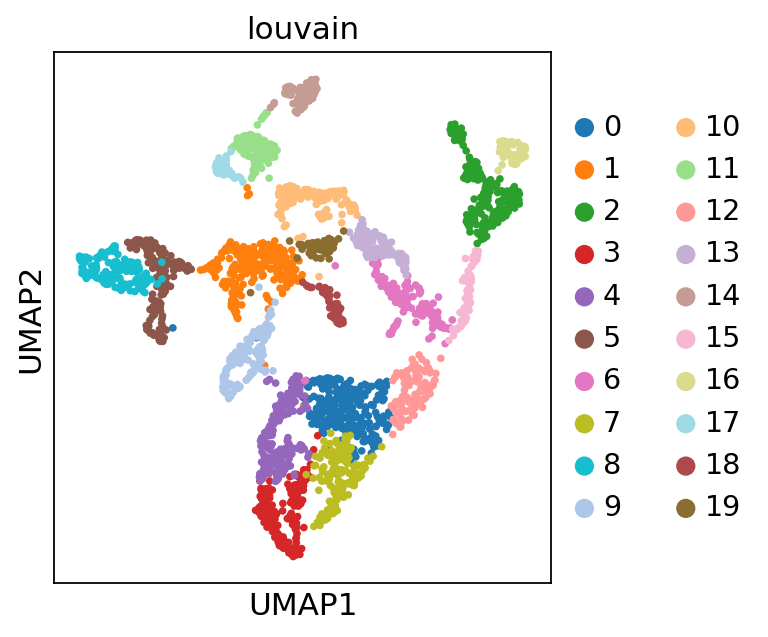

In [14]:
sc.pl.umap(adata, color='louvain')

## Compute and plot tSNE

In [15]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:47.73) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


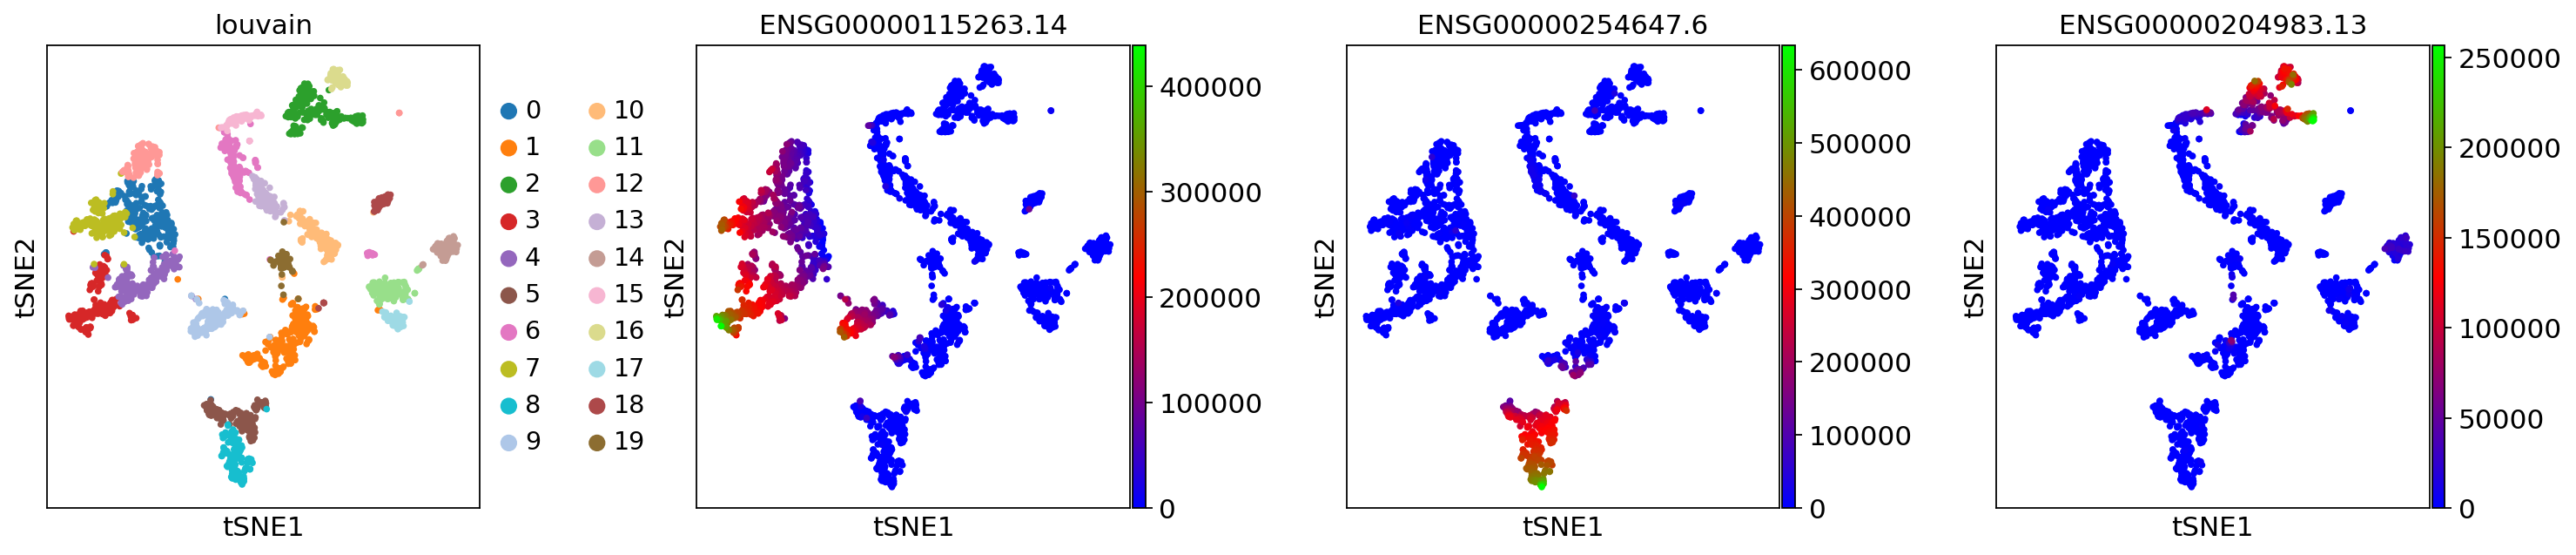

In [16]:
sc.pl.tsne(adata, color=['louvain', 'ENSG00000115263.14', 'ENSG00000254647.6', 'ENSG00000204983.13'])

In [17]:
adata.write(results_file)